# IANNwTF Homework 2 Submission


## Defining the model.

In [1]:
# Do import
import numpy as np
from matplotlib import pyplot as plt

#### Ex. 1 Define Sigmoid and Sigmoid's first derivative.

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_prime(x):
    """Return first derivative of sigmoid."""
    return sigmoid(x) * (1 - sigmoid(x))


# In case we want to use a different activation function.
# Store for each function the 0th and 1st derivative as list
FUNCS = {"sigmoid": [sigmoid, sigmoid_prime]}

#### Ex. 3 Implement Perceptron.

In [3]:
class Perceptron:

    def __init__(self, input_units, func_name):
        """

        :param input_units: input dimension
        :param func_name: the activation function
        """
        self.act_func = FUNCS[func_name][0]
        self.act_func_prime = FUNCS[func_name][1]
        self.input_units = input_units
        # 1. Initialize random weights and a random bias term. Check 'np.random.randn()'.
        self.weights = np.random.randn(input_units)
        self.bias = np.random.randn()
        # 2. Define the learning rate as 1.
        self.alpha = 1
        # Field that stores last received input and drive in member function forward_step. Used for backpropagation
        self.input = None
        self.drive = None

    def forward_step(self, input):
        # Perform a perceptron forward step.
        # 1. Calculate the drive. You can use @ as a matrix multiplication command.
        # Store input and drive for later usage for backprop
        self.input = input
        self.drive = self.weights @ input + self.bias
        # An alternative would be:
        # weighted_sum =  np.dot(drive, self.weights) + self.bias

        # 2. Return activation function's output
        return self.act_func(self.drive)

    def update(self, delta_i):
        """
        update weights of Perceptron

        :param delta_i: the i-th entry of error signal. Is a scalar
        """
        self.weights -= self.alpha * delta_i * np.array(self.input)
        self.bias -= self.alpha * delta_i

    # member function from the Perceptron class from the
    # Flipped classroom that we don't need anymore
    """
    def training_step(self, input, label):
        # Perform a whole training step (including the forward step).
        # 1. Forward step.
        prediction = self.forward_step(input)
        # 2. Calculate the weight updates.
        delta_weights = self.alpha * (label - prediction) * input
        # 3. Calculate the bias update. We consider 1 as the "drive" to the bias,
        # so that we can treat it just like t
        # he other weights.
        delta_bias = self.alpha * (label - prediction) * 1
        # 4. Update weights and bias.
        self.weights += delta_weights
        self.bias += delta_bias
    """

#### Ex. 4 Implement Multi-layer Perceptron.

In [4]:
class MLP:

    def __init__(self, input_units, hidden_structure, func_name):
        """

        :param input_units: input data dimension
        :param hidden_structure: specifies the architecture of the MLP
        :param func_name: activation function of hidden layers' perceptrons
        """
        # stores Perceptrons of hidden layers
        self.layers = []
        prev_output_units = input_units
        # iterate through layers
        for i, layer_dim in enumerate(hidden_structure):
            hidden_layer = []

            # initialize and store Perceptrons of layer i
            for j in range(layer_dim):
                hidden_layer.append(Perceptron(prev_output_units, func_name))

            # this layer's output dim is next layer's input dim
            prev_output_units = layer_dim
            # add layer to hidden_layers
            self.layers.append(hidden_layer)

        self.output = Perceptron(prev_output_units, func_name)

    def forward_step(self, input):
        inp = input

        for layer in self.layers:
            out = []
            # compute output of current layer and store as next_inp for next layer
            for perc in layer:
                # collect each perceptron's output as vector
                out.append(perc.forward_step(inp))
            # this output is input for next layer
            inp = out

        # don't forget the output neuron
        return self.output.forward_step(inp)

    def backprop_step(self, out_delta):
        """
        Backpropagate loss and update weights

        :param out_delta: delta_i for output neuron
        """

        # compute part of delta for last hidden layer before weights get updated with last.update.
        current_delta = self.output.weights * out_delta
        self.output.update(out_delta)

        # Compute backprop for hidden layer neurons
        for layer in reversed(self.layers):
            # saves delta for next layer
            next_delta = np.zeros(layer[0].weights.shape)
            # for the i-th perceptron in current layer, do:
            for i, perc in enumerate(layer):
                # complete i-th entry of current_delta. This is a scalar only multiplication
                current_delta[i] = current_delta[i] * np.array(perc.act_func_prime(perc.drive))
                # compute part of new_delta
                next_delta += current_delta[i] * perc.weights
                # feed in i-th entry of old_delta to i-th perceptron
                perc.update(current_delta[i])
            #  next_delta becomes current_delta for next layer
            current_delta = next_delta

    def training_step(self, input, label):
        """
        Train network for one step

        :param input: training datum
        :param label: true output of input
        """
        # Do forward_step and compute loss
        out = self.forward_step(input)
        last = self.output
        # computation for out_delta
        last_delta = -(label - out) * last.act_func_prime(last.drive)
        self.backprop_step(last_delta)

## Training the model.

#### Ex.2 Data prepration.

In [5]:
# These are the four possible input pairs of (x1,x2).
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

# These are possible labels form some logical gates.
labels = {"AND": np.array([0, 0, 0, 1]),
          "OR": np.array([0, 1, 1, 1]),
          "NAND": np.array([1, 1, 1, 0]),
          "NOR": np.array([1, 0, 0, 0]),
          "XOR": np.array([0, 1, 1, 0])}


#### Ex. 5 Actual training.

In [6]:
# records statistics of all datasets
all_steps = {}
all_losses = {}
all_accuracies = {}

# for each data set
for key in labels:

    # instantiate MLP model
    mlp = MLP(2, [4], "sigmoid")

    # track statistics for current dataset
    accuracies = []
    losses = []
    steps = []

    for epoch in range(1000):
        steps.append(epoch)

        # track statistics for this epoch
        accuracy_sum = 0
        loss_sum = 0

        # iterate over all data points
        for inp, t in zip(x, labels[key]):
            # update weights
            mlp.training_step(inp, t)
            # get predictions...
            # probabilistic prediction
            prob_pred = mlp.forward_step(inp)
            # deterministic prediction
            discrete_pred = int(prob_pred >= 0.5)
            # record accuracy
            accuracy_sum += discrete_pred == t
            # record loss
            loss_sum += (prob_pred - t) ** 2

        # record average values
        accuracies.append(accuracy_sum / 4)
        losses.append(loss_sum / 4)

    # record statistics for later use in plotting
    all_steps[key] = steps
    all_losses[key] = losses
    all_accuracies[key] = accuracies

#### Ex. 6 Plot the statistics for all the data sets.

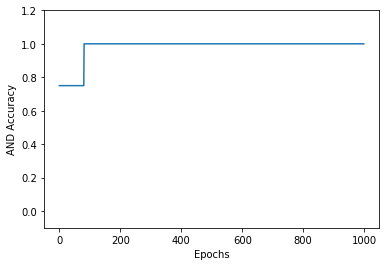

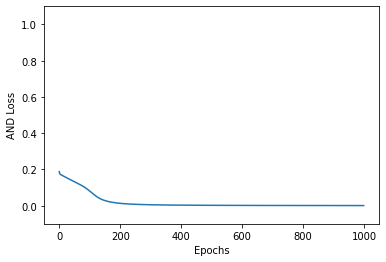

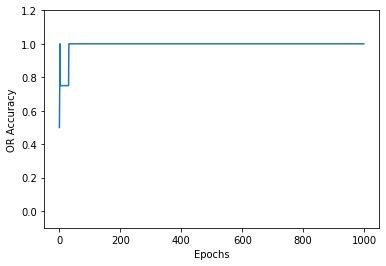

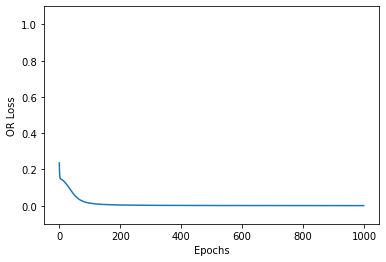

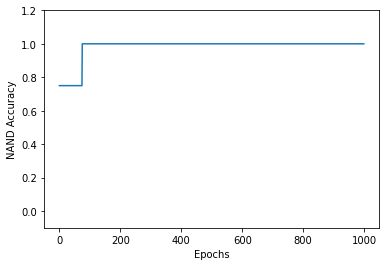

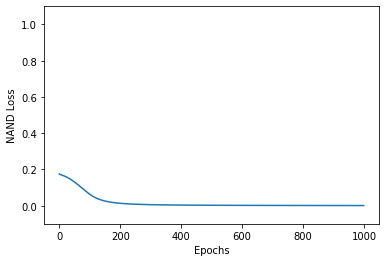

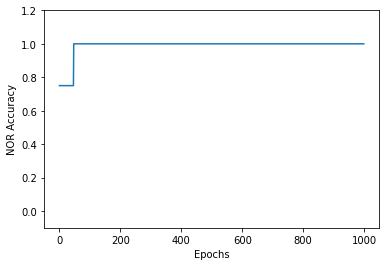

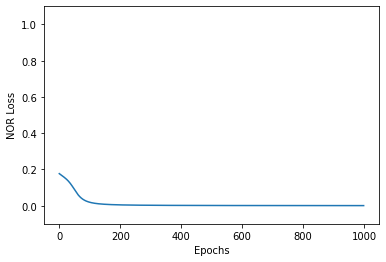

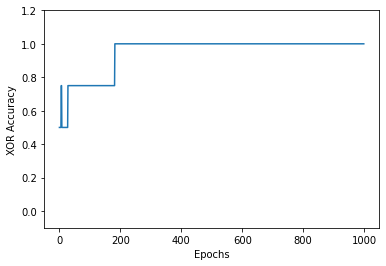

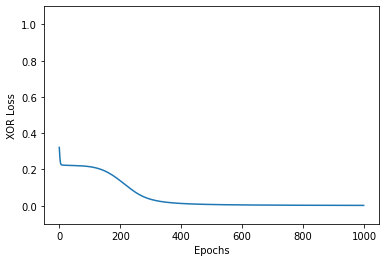

In [7]:
for key in all_steps:

    steps = all_steps[key]
    losses = all_losses[key]
    accuracies = all_accuracies[key]

    ylabel_part = key + " "

    # plot accuracy
    plt.figure()
    plt.plot(steps, accuracies)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel_part + "Accuracy")
    # accuracy is between 0 and 1
    plt.ylim([-0.1, 1.2])
    plt.show()

    # plot loss
    plt.figure()
    plt.plot(steps, losses)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel_part + "Loss")
    # loss is between 0 and 1
    plt.ylim([-0.1, 1.1])
    plt.show()


